In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

In [4]:
date = "20190813"
run_name = "08_13_2019_run_03"
molbit_file = "../porcupine_sequences.fa"
run_data = dict(run_spreadsheet[run_spreadsheet["run_name"] == run_name].iloc[0, :])

In [5]:
fastq_dir = os.path.join(run_data["basecall_dir"], "pass")

# Run sequence alignment

In [7]:
def read_fasta(fasta_fname):
    '''Assumes 1 line per sequence.'''
    seqs = []
    names = []
    with open(fasta_fname) as fa:
        for line in fa:
            line = line.strip()
            if line.startswith(">"):
                names.append(line.replace(">", "").split()[0])
            else:
                seqs.append(line)
    return seqs, names

In [8]:
def read_fastq(fastq_fname):
    seqs = []
    with open(fastq_fname) as fq:
        fq = fq.readlines()
        for line_i in range(0, len(fq), 4):
            line = fq[line_i].strip().split(" ")
            read_id = str(line[0])[1:]
            seq = fq[line_i + 1].strip()
            seqs.append((read_id, seq))
    return seqs

In [9]:
from pore_utils import smith_waterman as s_w

In [10]:
def helper_run_sw(read, molbit_seqs=None, search_len=100,
                  cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    read_id, seq = read

    sw_search_end = min(len(seq), search_len)
    search_seq = seq[:sw_search_end]

    results = [read_id]
    for header_i, header_seq in enumerate(molbit_seqs):
        _, sw_score, _, sw_loc, _ = s_w.s_w(search_seq, header_seq,
                                        cost_fn=cost_fn)
        results.append(sw_score)
    return results


def run_sw(fastq_dir, out_dir, search_len=80, molbit_fa=None, n_workers=20,
           cost_fn={"match": 2, "mismatch": -2, "gap": -1}):
    os.makedirs(out_dir)
    import dask.bag as db
    from dask.diagnostics import ProgressBar
    ProgressBar().register()
    
    logger.info("Getting molbit sequences.")
    assert molbit_fa is not None
    assert os.path.exists(molbit_fa)
    molbit_seqs, molbit_names = read_fasta(molbit_fa)
    
    logger.info("Locating fastq files.")
    fastq_files = []
    for fname in os.listdir(fastq_dir):
        if fname.endswith(".fastq"):
            fastq_files.append(os.path.join(fastq_dir, fname))
    assert len(fastq_files) > 0
    
    logger.info("Running SW, one fastq at a time.")
    for fq_i, fq_fname in enumerate(fastq_files):
        logger.info(f"Starting fastq ({fq_i} of {len(fastq_files)})\n\t{fq_fname}")
        fq_seqs = read_fastq(fq_fname)
        
        bag = db.from_sequence(fq_seqs)
        dask_map = bag.map(helper_run_sw, molbit_seqs=molbit_seqs,
                           search_len=search_len, cost_fn=cost_fn)
        sw_scores = dask_map.compute(num_workers=n_workers)
        
        cols = ["read_id"] + [f"sw_score_molbit_{molbit}" for molbit in molbit_names]
        sw_df = pd.DataFrame(sw_scores, columns=cols)
        sw_df.index = sw_df["read_id"]
        del sw_df["read_id"]
        out_fname = fq_fname.split("/")[-1].replace(".fastq", "") + ".tsv"
        out_fname = os.path.join(out_dir, out_fname)
        logger.info(f"Saving to file: {out_fname}")
        sw_df.to_csv(out_fname, sep="\t", index=True)

In [11]:
sw_dir = os.path.join(run_data["basecall_dir"], "sw")
cost_fn = {"match": 1, "mismatch": -1, "gap": -8}

In [ ]:
run_sw(fastq_dir, sw_dir, search_len=80, cost_fn=cost_fn, molbit_fa=molbit_file, n_workers=40)

[08:34:18 - __main__] Getting molbit sequences.
[08:34:18 - __main__] Locating fastq files.
[08:34:18 - __main__] Running SW, one fastq at a time.
[08:34:18 - __main__] Starting fastq (0 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_0.fastq


[########################################] | 100% Completed | 41.4s


[08:35:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_0.tsv
[08:35:00 - __main__] Starting fastq (1 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_1.fastq


[########################################] | 100% Completed | 35.9s


[08:35:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_1.tsv
[08:35:36 - __main__] Starting fastq (2 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_2.fastq


[########################################] | 100% Completed | 33.7s


[08:36:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_2.tsv
[08:36:10 - __main__] Starting fastq (3 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_3.fastq


[########################################] | 100% Completed | 25.6s


[08:36:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_0_3.tsv
[08:36:36 - __main__] Starting fastq (4 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_0.fastq


[########################################] | 100% Completed | 31.4s


[08:37:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_0.tsv
[08:37:08 - __main__] Starting fastq (5 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_1.fastq


[########################################] | 100% Completed | 27.6s


[08:37:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_1.tsv
[08:37:36 - __main__] Starting fastq (6 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_2.fastq


[########################################] | 100% Completed | 36.3s


[08:38:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_2.tsv
[08:38:13 - __main__] Starting fastq (7 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_3.fastq


[########################################] | 100% Completed | 35.6s


[08:38:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_1_3.tsv
[08:38:49 - __main__] Starting fastq (8 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_0.fastq


[########################################] | 100% Completed | 49.8s


[08:39:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_0.tsv
[08:39:39 - __main__] Starting fastq (9 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_1.fastq


[########################################] | 100% Completed | 39.9s


[08:40:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_1.tsv
[08:40:19 - __main__] Starting fastq (10 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_2.fastq


[########################################] | 100% Completed | 13.5s


[08:40:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_2.tsv
[08:40:33 - __main__] Starting fastq (11 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_0.fastq


[########################################] | 100% Completed | 39.9s


[08:41:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_0.tsv
[08:41:13 - __main__] Starting fastq (12 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_3.fastq


[########################################] | 100% Completed | 27.4s


[08:41:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_2_3.tsv
[08:41:41 - __main__] Starting fastq (13 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_1.fastq


[########################################] | 100% Completed | 41.9s


[08:42:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_1.tsv
[08:42:23 - __main__] Starting fastq (14 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_2.fastq


[########################################] | 100% Completed | 35.5s


[08:42:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_2.tsv
[08:42:59 - __main__] Starting fastq (15 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_3.fastq


[########################################] | 100% Completed | 15.1s


[08:43:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_3_3.tsv
[08:43:14 - __main__] Starting fastq (16 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_0.fastq


[########################################] | 100% Completed | 34.9s


[08:43:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_0.tsv
[08:43:50 - __main__] Starting fastq (17 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_1.fastq


[########################################] | 100% Completed | 32.7s


[08:44:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_1.tsv
[08:44:23 - __main__] Starting fastq (18 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_2.fastq


[########################################] | 100% Completed |  1min  6.9s


[08:45:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_2.tsv
[08:45:30 - __main__] Starting fastq (19 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_3.fastq


[########################################] | 100% Completed |  1.8s


[08:45:32 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_4_3.tsv
[08:45:32 - __main__] Starting fastq (20 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_0.fastq


[########################################] | 100% Completed | 47.6s


[08:46:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_0.tsv
[08:46:20 - __main__] Starting fastq (21 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_1.fastq


[########################################] | 100% Completed | 35.8s


[08:46:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_1.tsv
[08:46:56 - __main__] Starting fastq (22 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_2.fastq


[########################################] | 100% Completed | 39.7s


[08:47:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_2.tsv
[08:47:36 - __main__] Starting fastq (23 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_3.fastq


[########################################] | 100% Completed |  8.1s


[08:47:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_5_3.tsv
[08:47:45 - __main__] Starting fastq (24 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_0.fastq


[########################################] | 100% Completed |  1min 10.2s


[08:48:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_0.tsv
[08:48:55 - __main__] Starting fastq (25 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_1.fastq


[########################################] | 100% Completed | 52.5s


[08:49:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_1.tsv
[08:49:48 - __main__] Starting fastq (26 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_2.fastq


[########################################] | 100% Completed |  7.5s


[08:49:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_2.tsv
[08:49:56 - __main__] Starting fastq (27 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_3.fastq


[########################################] | 100% Completed |  4.1s


[08:50:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_6_3.tsv
[08:50:00 - __main__] Starting fastq (28 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_0.fastq


[########################################] | 100% Completed | 51.8s


[08:50:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_0.tsv
[08:50:53 - __main__] Starting fastq (29 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_1.fastq


[########################################] | 100% Completed | 35.6s


[08:51:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_1.tsv
[08:51:28 - __main__] Starting fastq (30 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_2.fastq


[########################################] | 100% Completed | 39.5s


[08:52:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_2.tsv
[08:52:08 - __main__] Starting fastq (31 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_3.fastq


[########################################] | 100% Completed |  7.0s


[08:52:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_7_3.tsv
[08:52:16 - __main__] Starting fastq (32 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_0.fastq


[########################################] | 100% Completed | 59.5s


[08:53:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_0.tsv
[08:53:16 - __main__] Starting fastq (33 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_1.fastq


[########################################] | 100% Completed |  1min  1.1s


[08:54:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_1.tsv
[08:54:17 - __main__] Starting fastq (34 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_2.fastq


[########################################] | 100% Completed | 13.0s


[08:54:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_2.tsv
[08:54:30 - __main__] Starting fastq (35 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_0.fastq


[########################################] | 100% Completed | 29.0s


[08:55:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_0.tsv
[08:55:00 - __main__] Starting fastq (36 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_3.fastq


[########################################] | 100% Completed |  0.8s


[08:55:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_8_3.tsv
[08:55:01 - __main__] Starting fastq (37 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_1.fastq


[########################################] | 100% Completed | 49.5s


[08:55:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_1.tsv
[08:55:51 - __main__] Starting fastq (38 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_2.fastq


[########################################] | 100% Completed | 40.3s


[08:56:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_2.tsv
[08:56:31 - __main__] Starting fastq (39 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_3.fastq


[########################################] | 100% Completed | 11.5s


[08:56:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_9_3.tsv
[08:56:43 - __main__] Starting fastq (40 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_0.fastq


[########################################] | 100% Completed |  1min  7.6s


[08:57:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_0.tsv
[08:57:51 - __main__] Starting fastq (41 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_1.fastq


[########################################] | 100% Completed | 35.9s


[08:58:27 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_1.tsv
[08:58:27 - __main__] Starting fastq (42 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_2.fastq


[########################################] | 100% Completed | 26.3s


[08:58:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_2.tsv
[08:58:54 - __main__] Starting fastq (43 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_3.fastq


[########################################] | 100% Completed |  1.0s


[08:58:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_10_3.tsv
[08:58:55 - __main__] Starting fastq (44 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_0.fastq


[########################################] | 100% Completed | 39.0s


[08:59:35 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_0.tsv
[08:59:35 - __main__] Starting fastq (45 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_1.fastq


[########################################] | 100% Completed |  1min  3.8s


[09:00:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_1.tsv
[09:00:39 - __main__] Starting fastq (46 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_2.fastq


[########################################] | 100% Completed | 23.6s


[09:01:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_2.tsv
[09:01:03 - __main__] Starting fastq (47 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_3.fastq


[########################################] | 100% Completed |  6.4s


[09:01:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_11_3.tsv
[09:01:09 - __main__] Starting fastq (48 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_0.fastq


[########################################] | 100% Completed | 37.7s


[09:01:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_0.tsv
[09:01:47 - __main__] Starting fastq (49 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_1.fastq


[########################################] | 100% Completed | 35.7s


[09:02:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_1.tsv
[09:02:23 - __main__] Starting fastq (50 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_2.fastq


[########################################] | 100% Completed | 22.0s


[09:02:46 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_2.tsv
[09:02:46 - __main__] Starting fastq (51 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_0.fastq


[########################################] | 100% Completed | 34.4s


[09:03:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_0.tsv
[09:03:21 - __main__] Starting fastq (52 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_1.fastq


[########################################] | 100% Completed | 47.3s


[09:04:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_1.tsv
[09:04:08 - __main__] Starting fastq (53 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_2.fastq


[########################################] | 100% Completed | 48.3s


[09:04:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_2.tsv
[09:04:57 - __main__] Starting fastq (54 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_3.fastq


[########################################] | 100% Completed | 38.9s


[09:05:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_12_3.tsv
[09:05:36 - __main__] Starting fastq (55 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_0.fastq


[########################################] | 100% Completed | 44.0s


[09:06:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_0.tsv
[09:06:21 - __main__] Starting fastq (56 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_1.fastq


[########################################] | 100% Completed | 43.1s


[09:07:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_1.tsv
[09:07:04 - __main__] Starting fastq (57 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_2.fastq


[########################################] | 100% Completed | 40.1s


[09:07:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_2.tsv
[09:07:45 - __main__] Starting fastq (58 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_0.fastq


[########################################] | 100% Completed | 16.9s


[09:08:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_0.tsv
[09:08:02 - __main__] Starting fastq (59 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_1.fastq


[########################################] | 100% Completed |  1min  5.4s


[09:09:07 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_1.tsv
[09:09:07 - __main__] Starting fastq (60 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_3.fastq


[########################################] | 100% Completed |  2.3s


[09:09:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_13_3.tsv
[09:09:10 - __main__] Starting fastq (61 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_3.fastq


[########################################] | 100% Completed |  4.2s


[09:09:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_14_3.tsv
[09:09:14 - __main__] Starting fastq (62 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_2.fastq


[########################################] | 100% Completed | 27.3s


[09:09:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_2.tsv
[09:09:42 - __main__] Starting fastq (63 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_0.fastq


[########################################] | 100% Completed | 47.5s


[09:10:30 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_0.tsv
[09:10:30 - __main__] Starting fastq (64 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_1.fastq


[########################################] | 100% Completed | 54.6s


[09:11:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_1.tsv
[09:11:25 - __main__] Starting fastq (65 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_3.fastq


[########################################] | 100% Completed | 22.3s


[09:11:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_15_3.tsv
[09:11:48 - __main__] Starting fastq (66 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_2.fastq


[########################################] | 100% Completed | 26.8s


[09:12:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_2.tsv
[09:12:15 - __main__] Starting fastq (67 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_0.fastq


[########################################] | 100% Completed | 14.4s


[09:12:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_0.tsv
[09:12:29 - __main__] Starting fastq (68 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_1.fastq


[########################################] | 100% Completed | 35.5s


[09:13:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_1.tsv
[09:13:05 - __main__] Starting fastq (69 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_2.fastq


[########################################] | 100% Completed |  1min 17.1s


[09:14:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_2.tsv
[09:14:23 - __main__] Starting fastq (70 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_0.fastq


[########################################] | 100% Completed | 42.1s


[09:15:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_0.tsv
[09:15:05 - __main__] Starting fastq (71 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_3.fastq


[########################################] | 100% Completed |  8.9s


[09:15:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_16_3.tsv
[09:15:14 - __main__] Starting fastq (72 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_3.fastq


[########################################] | 100% Completed |  4.9s


[09:15:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_17_3.tsv
[09:15:20 - __main__] Starting fastq (73 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_1.fastq


[########################################] | 100% Completed | 43.4s


[09:16:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_1.tsv
[09:16:03 - __main__] Starting fastq (74 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_2.fastq


[########################################] | 100% Completed | 47.1s


[09:16:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_2.tsv
[09:16:51 - __main__] Starting fastq (75 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_0.fastq


[########################################] | 100% Completed | 32.2s


[09:17:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_0.tsv
[09:17:23 - __main__] Starting fastq (76 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_1.fastq


[########################################] | 100% Completed | 35.5s


[09:17:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_1.tsv
[09:17:59 - __main__] Starting fastq (77 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_2.fastq


[########################################] | 100% Completed | 58.4s


[09:18:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_2.tsv
[09:18:58 - __main__] Starting fastq (78 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_0.fastq


[########################################] | 100% Completed |  1min  4.0s


[09:20:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_0.tsv
[09:20:03 - __main__] Starting fastq (79 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_1.fastq


[########################################] | 100% Completed |  9.7s


[09:20:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_1.tsv
[09:20:13 - __main__] Starting fastq (80 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_3.fastq


[########################################] | 100% Completed |  1.0s


[09:20:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_18_3.tsv
[09:20:14 - __main__] Starting fastq (81 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_3.fastq


[########################################] | 100% Completed |  6.0s


[09:20:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_19_3.tsv
[09:20:20 - __main__] Starting fastq (82 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_2.fastq


[########################################] | 100% Completed | 30.1s


[09:20:50 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_2.tsv
[09:20:51 - __main__] Starting fastq (83 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_0.fastq


[########################################] | 100% Completed | 31.1s


[09:21:22 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_0.tsv
[09:21:22 - __main__] Starting fastq (84 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_1.fastq


[########################################] | 100% Completed | 35.9s


[09:21:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_1.tsv
[09:21:58 - __main__] Starting fastq (85 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_3.fastq


[########################################] | 100% Completed | 26.0s


[09:22:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_20_3.tsv
[09:22:24 - __main__] Starting fastq (86 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_2.fastq


[########################################] | 100% Completed |  1min  4.0s


[09:23:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_2.tsv
[09:23:29 - __main__] Starting fastq (87 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_0.fastq


[########################################] | 100% Completed |  1min  9.2s


[09:24:38 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_0.tsv
[09:24:39 - __main__] Starting fastq (88 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_3.fastq


[########################################] | 100% Completed |  0.9s


[09:24:40 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_21_3.tsv
[09:24:40 - __main__] Starting fastq (89 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_1.fastq


[########################################] | 100% Completed | 39.0s


[09:25:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_1.tsv
[09:25:19 - __main__] Starting fastq (90 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_2.fastq


[########################################] | 100% Completed | 23.0s


[09:25:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_2.tsv
[09:25:42 - __main__] Starting fastq (91 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_0.fastq


[########################################] | 100% Completed | 48.1s


[09:26:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_0.tsv
[09:26:31 - __main__] Starting fastq (92 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_1.fastq


[########################################] | 100% Completed | 31.1s


[09:27:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_1.tsv
[09:27:02 - __main__] Starting fastq (93 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_3.fastq


[########################################] | 100% Completed |  1.0s


[09:27:04 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_22_3.tsv
[09:27:04 - __main__] Starting fastq (94 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_0.fastq


[########################################] | 100% Completed |  1min  7.6s


[09:28:11 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_0.tsv
[09:28:12 - __main__] Starting fastq (95 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_2.fastq


[########################################] | 100% Completed |  1.8s


[09:28:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_2.tsv
[09:28:14 - __main__] Starting fastq (96 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_3.fastq


[########################################] | 100% Completed |  0.9s


[09:28:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_23_3.tsv
[09:28:15 - __main__] Starting fastq (97 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_1.fastq


[########################################] | 100% Completed | 14.3s


[09:28:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_1.tsv
[09:28:30 - __main__] Starting fastq (98 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_2.fastq


[########################################] | 100% Completed | 38.7s


[09:29:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_2.tsv
[09:29:09 - __main__] Starting fastq (99 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_3.fastq


[########################################] | 100% Completed | 10.1s


[09:29:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_24_3.tsv
[09:29:19 - __main__] Starting fastq (100 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_0.fastq


[########################################] | 100% Completed | 47.1s


[09:30:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_0.tsv
[09:30:06 - __main__] Starting fastq (101 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_1.fastq


[########################################] | 100% Completed | 50.2s


[09:30:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_1.tsv
[09:30:57 - __main__] Starting fastq (102 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_2.fastq


[########################################] | 100% Completed | 22.8s


[09:31:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_2.tsv
[09:31:20 - __main__] Starting fastq (103 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_3.fastq


[########################################] | 100% Completed | 13.8s


[09:31:34 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_25_3.tsv
[09:31:34 - __main__] Starting fastq (104 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_0.fastq


[########################################] | 100% Completed | 37.7s


[09:32:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_0.tsv
[09:32:12 - __main__] Starting fastq (105 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_1.fastq


[########################################] | 100% Completed | 34.4s


[09:32:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_1.tsv
[09:32:47 - __main__] Starting fastq (106 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_2.fastq


[########################################] | 100% Completed | 43.7s


[09:33:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_2.tsv
[09:33:31 - __main__] Starting fastq (107 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_3.fastq


[########################################] | 100% Completed | 19.9s


[09:33:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_26_3.tsv
[09:33:51 - __main__] Starting fastq (108 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_0.fastq


[########################################] | 100% Completed | 16.8s


[09:34:08 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_0.tsv
[09:34:08 - __main__] Starting fastq (109 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_1.fastq


[########################################] | 100% Completed | 43.5s


[09:34:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_1.tsv
[09:34:52 - __main__] Starting fastq (110 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_2.fastq


[########################################] | 100% Completed | 50.0s


[09:35:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_2.tsv
[09:35:43 - __main__] Starting fastq (111 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_3.fastq


[########################################] | 100% Completed | 22.3s


[09:36:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_27_3.tsv
[09:36:05 - __main__] Starting fastq (112 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_0.fastq


[########################################] | 100% Completed | 43.3s


[09:36:49 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_0.tsv
[09:36:49 - __main__] Starting fastq (113 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_1.fastq


[########################################] | 100% Completed | 26.8s


[09:37:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_1.tsv
[09:37:16 - __main__] Starting fastq (114 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_2.fastq


[########################################] | 100% Completed | 40.4s


[09:37:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_2.tsv
[09:37:57 - __main__] Starting fastq (115 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_3.fastq


[########################################] | 100% Completed | 19.8s


[09:38:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_28_3.tsv
[09:38:17 - __main__] Starting fastq (116 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_0.fastq


[########################################] | 100% Completed | 49.0s


[09:39:06 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_0.tsv
[09:39:06 - __main__] Starting fastq (117 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_1.fastq


[########################################] | 100% Completed | 30.1s


[09:39:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_1.tsv
[09:39:37 - __main__] Starting fastq (118 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_2.fastq


[########################################] | 100% Completed | 41.3s


[09:40:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_2.tsv
[09:40:19 - __main__] Starting fastq (119 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_3.fastq


[########################################] | 100% Completed | 11.9s


[09:40:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_29_3.tsv
[09:40:31 - __main__] Starting fastq (120 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_0.fastq


[########################################] | 100% Completed | 58.0s


[09:41:29 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_0.tsv
[09:41:29 - __main__] Starting fastq (121 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_1.fastq


[########################################] | 100% Completed | 23.0s


[09:41:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_1.tsv
[09:41:52 - __main__] Starting fastq (122 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_2.fastq


[########################################] | 100% Completed | 44.0s


[09:42:37 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_2.tsv
[09:42:37 - __main__] Starting fastq (123 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_3.fastq


[########################################] | 100% Completed |  7.3s


[09:42:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_30_3.tsv
[09:42:44 - __main__] Starting fastq (124 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_0.fastq


[########################################] | 100% Completed |  1min 28.3s


[09:44:13 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_0.tsv
[09:44:13 - __main__] Starting fastq (125 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_1.fastq


[########################################] | 100% Completed | 39.5s


[09:44:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_1.tsv
[09:44:53 - __main__] Starting fastq (126 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_0.fastq


[########################################] | 100% Completed |  1min 45.4s


[09:46:39 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_0.tsv
[09:46:39 - __main__] Starting fastq (127 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_2.fastq


[########################################] | 100% Completed |  4.0s


[09:46:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_2.tsv
[09:46:43 - __main__] Starting fastq (128 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_1.fastq


[########################################] | 100% Completed |  4.2s


[09:46:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_1.tsv
[09:46:48 - __main__] Starting fastq (129 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_0.fastq


[########################################] | 100% Completed | 35.3s


[09:47:23 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_0.tsv
[09:47:23 - __main__] Starting fastq (130 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_3.fastq


[########################################] | 100% Completed |  1.0s


[09:47:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_31_3.tsv
[09:47:24 - __main__] Starting fastq (131 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_2.fastq


[########################################] | 100% Completed |  1.0s


[09:47:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_2.tsv
[09:47:26 - __main__] Starting fastq (132 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_1.fastq


[########################################] | 100% Completed |  1min 16.3s


[09:48:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_1.tsv
[09:48:43 - __main__] Starting fastq (133 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_3.fastq


[########################################] | 100% Completed | 21.9s


[09:49:05 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_32_3.tsv
[09:49:05 - __main__] Starting fastq (134 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_0.fastq


[########################################] | 100% Completed |  1min  3.6s


[09:50:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_0.tsv
[09:50:09 - __main__] Starting fastq (135 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_2.fastq


[########################################] | 100% Completed |  1.0s


[09:50:10 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_2.tsv
[09:50:10 - __main__] Starting fastq (136 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_1.fastq


[########################################] | 100% Completed | 42.4s


[09:50:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_1.tsv
[09:50:53 - __main__] Starting fastq (137 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_2.fastq


[########################################] | 100% Completed | 23.2s


[09:51:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_2.tsv
[09:51:17 - __main__] Starting fastq (138 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_0.fastq


[########################################] | 100% Completed | 39.5s


[09:51:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_0.tsv
[09:51:56 - __main__] Starting fastq (139 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_1.fastq


[########################################] | 100% Completed | 28.9s


[09:52:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_1.tsv
[09:52:26 - __main__] Starting fastq (140 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_3.fastq


[########################################] | 100% Completed | 19.1s


[09:52:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_33_3.tsv
[09:52:45 - __main__] Starting fastq (141 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_3.fastq


[########################################] | 100% Completed |  2.7s


[09:52:48 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_34_3.tsv
[09:52:48 - __main__] Starting fastq (142 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_2.fastq


[########################################] | 100% Completed | 25.8s


[09:53:14 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_2.tsv
[09:53:14 - __main__] Starting fastq (143 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_3.fastq


[########################################] | 100% Completed | 39.7s


[09:53:54 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_35_3.tsv
[09:53:54 - __main__] Starting fastq (144 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_0.fastq


[########################################] | 100% Completed | 38.4s


[09:54:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_0.tsv
[09:54:33 - __main__] Starting fastq (145 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_1.fastq


[########################################] | 100% Completed | 35.5s


[09:55:09 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_1.tsv
[09:55:09 - __main__] Starting fastq (146 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_2.fastq


[########################################] | 100% Completed | 38.0s


[09:55:47 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_2.tsv
[09:55:47 - __main__] Starting fastq (147 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_0.fastq


[########################################] | 100% Completed | 28.2s


[09:56:16 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_0.tsv
[09:56:16 - __main__] Starting fastq (148 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_3.fastq


[########################################] | 100% Completed | 20.2s


[09:56:36 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_36_3.tsv
[09:56:36 - __main__] Starting fastq (149 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_1.fastq


[########################################] | 100% Completed | 48.3s


[09:57:25 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_1.tsv
[09:57:25 - __main__] Starting fastq (150 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_2.fastq


[########################################] | 100% Completed | 28.1s


[09:57:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_2.tsv
[09:57:53 - __main__] Starting fastq (151 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_3.fastq


[########################################] | 100% Completed | 27.3s


[09:58:21 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_37_3.tsv
[09:58:21 - __main__] Starting fastq (152 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_0.fastq


[########################################] | 100% Completed | 57.0s


[09:59:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_0.tsv
[09:59:19 - __main__] Starting fastq (153 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_1.fastq


[########################################] | 100% Completed | 14.4s


[09:59:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_1.tsv
[09:59:33 - __main__] Starting fastq (154 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_2.fastq


[########################################] | 100% Completed | 30.0s


[10:00:03 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_2.tsv
[10:00:04 - __main__] Starting fastq (155 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_0.fastq


[########################################] | 100% Completed | 57.1s


[10:01:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_0.tsv
[10:01:01 - __main__] Starting fastq (156 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_1.fastq


[########################################] | 100% Completed |  1min 17.0s


[10:02:18 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_1.tsv
[10:02:18 - __main__] Starting fastq (157 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_2.fastq


[########################################] | 100% Completed |  1.0s


[10:02:20 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_2.tsv
[10:02:20 - __main__] Starting fastq (158 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_0.fastq


[########################################] | 100% Completed | 39.6s


[10:03:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_0.tsv
[10:03:00 - __main__] Starting fastq (159 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_3.fastq


[########################################] | 100% Completed | 28.4s


[10:03:28 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_38_3.tsv
[10:03:28 - __main__] Starting fastq (160 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_1.fastq


[########################################] | 100% Completed | 23.2s


[10:03:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_1.tsv
[10:03:52 - __main__] Starting fastq (161 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_3.fastq


[########################################] | 100% Completed |  0.9s


[10:03:53 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_39_3.tsv
[10:03:53 - __main__] Starting fastq (162 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_2.fastq


[########################################] | 100% Completed | 37.5s


[10:04:31 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_2.tsv
[10:04:31 - __main__] Starting fastq (163 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_0.fastq


[########################################] | 100% Completed | 26.6s


[10:04:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_0.tsv
[10:04:58 - __main__] Starting fastq (164 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_1.fastq


[########################################] | 100% Completed | 58.2s


[10:05:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_1.tsv
[10:05:57 - __main__] Starting fastq (165 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_0.fastq


[########################################] | 100% Completed |  1min  0.8s


[10:06:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_0.tsv
[10:06:58 - __main__] Starting fastq (166 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_2.fastq


[########################################] | 100% Completed | 43.0s


[10:07:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_2.tsv
[10:07:41 - __main__] Starting fastq (167 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_1.fastq


[########################################] | 100% Completed | 42.3s


[10:08:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_1.tsv
[10:08:24 - __main__] Starting fastq (168 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_3.fastq


[########################################] | 100% Completed | 30.3s


[10:08:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_40_3.tsv
[10:08:55 - __main__] Starting fastq (169 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_3.fastq


[########################################] | 100% Completed |  7.3s


[10:09:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_41_3.tsv
[10:09:02 - __main__] Starting fastq (170 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_0.fastq


[########################################] | 100% Completed |  1min 13.9s


[10:10:17 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_0.tsv
[10:10:17 - __main__] Starting fastq (171 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_2.fastq


[########################################] | 100% Completed |  1.7s


[10:10:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_2.tsv
[10:10:19 - __main__] Starting fastq (172 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_1.fastq


[########################################] | 100% Completed | 37.3s


[10:10:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_1.tsv
[10:10:56 - __main__] Starting fastq (173 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_3.fastq


[########################################] | 100% Completed | 30.0s


[10:11:26 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_42_3.tsv
[10:11:27 - __main__] Starting fastq (174 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_2.fastq


[########################################] | 100% Completed |  6.4s


[10:11:33 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_2.tsv
[10:11:33 - __main__] Starting fastq (175 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_3.fastq


[########################################] | 100% Completed | 11.9s


[10:11:45 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_43_3.tsv
[10:11:45 - __main__] Starting fastq (176 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_0.fastq


[########################################] | 100% Completed | 11.9s


[10:11:58 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_0.tsv
[10:11:58 - __main__] Starting fastq (177 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_1.fastq


[########################################] | 100% Completed | 43.2s


[10:12:41 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_1.tsv
[10:12:41 - __main__] Starting fastq (178 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_2.fastq


[########################################] | 100% Completed |  1min 18.4s


[10:14:00 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_2.tsv
[10:14:00 - __main__] Starting fastq (179 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_0.fastq


[########################################] | 100% Completed |  1min  1.9s


[10:15:02 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_0.tsv
[10:15:02 - __main__] Starting fastq (180 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_1.fastq


[########################################] | 100% Completed | 48.2s


[10:15:51 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_1.tsv
[10:15:51 - __main__] Starting fastq (181 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_3.fastq


[########################################] | 100% Completed |  0.9s


[10:15:52 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_44_3.tsv
[10:15:52 - __main__] Starting fastq (182 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_2.fastq


[########################################] | 100% Completed |  4.9s


[10:15:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_2.tsv
[10:15:57 - __main__] Starting fastq (183 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_3.fastq


[########################################] | 100% Completed | 17.3s


[10:16:15 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_45_3.tsv
[10:16:15 - __main__] Starting fastq (184 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_0.fastq


[########################################] | 100% Completed | 44.3s


[10:16:59 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_0.tsv
[10:16:59 - __main__] Starting fastq (185 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_1.fastq


[########################################] | 100% Completed | 19.3s


[10:17:19 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_1.tsv
[10:17:19 - __main__] Starting fastq (186 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_2.fastq


[########################################] | 100% Completed | 23.1s


[10:17:42 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_2.tsv
[10:17:42 - __main__] Starting fastq (187 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_0.fastq


[########################################] | 100% Completed | 41.3s


[10:18:24 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_0.tsv
[10:18:24 - __main__] Starting fastq (188 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_1.fastq


[########################################] | 100% Completed | 47.3s


[10:19:12 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_1.tsv
[10:19:12 - __main__] Starting fastq (189 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_2.fastq


[########################################] | 100% Completed | 44.1s


[10:19:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_2.tsv
[10:19:56 - __main__] Starting fastq (190 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_3.fastq


[########################################] | 100% Completed | 46.6s


[10:20:43 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_46_3.tsv
[10:20:43 - __main__] Starting fastq (191 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_0.fastq


[########################################] | 100% Completed |  1min 17.6s


[10:22:01 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_0.tsv
[10:22:01 - __main__] Starting fastq (192 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_1.fastq


[########################################] | 100% Completed | 42.5s


[10:22:44 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_1.tsv
[10:22:44 - __main__] Starting fastq (193 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_2.fastq


[########################################] | 100% Completed | 10.1s


[10:22:55 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_2.tsv
[10:22:55 - __main__] Starting fastq (194 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_3.fastq


[########################################] | 100% Completed |  1.0s


[10:22:56 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_47_3.tsv
[10:22:56 - __main__] Starting fastq (195 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_3.fastq


[########################################] | 100% Completed |  1.0s


[10:22:57 - __main__] Saving to file: /path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_48_3.tsv
[10:22:57 - __main__] Starting fastq (196 of 309)
	/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/pass/fastq_runid_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657_49_0.fastq


[###############################         ] | 78% Completed | 55.3s

In [17]:
sw_list = []
for fname in os.listdir(sw_dir):
    sw_tsv = os.path.join(sw_dir, fname)
    sw = pd.read_csv(sw_tsv, sep="\t", index_col=0)
    sw_list.append(sw)
sw = pd.concat(sw_list)
del sw_list

In [19]:
sw_arr = np.array(sw)

In [21]:
max_sw = np.max(sw_arr, axis=1)
sw_arr[range(len(sw_arr)), np.argmax(sw_arr, axis=1)] = 0
second_best_sw = np.max(sw_arr, axis=1)
sw_arr = np.array(sw)

## Plot alignment scores for basic overview of performance

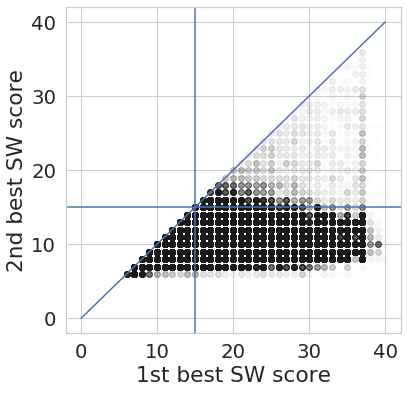

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(max_sw, second_best_sw, alpha=0.01, c="k")
ax.set_title("")
ax.set_xlabel("1st best SW score")
ax.set_ylabel("2nd best SW score")
ax.plot([0, 40], [0, 40])
ax.axhline(15)
ax.axvline(15)

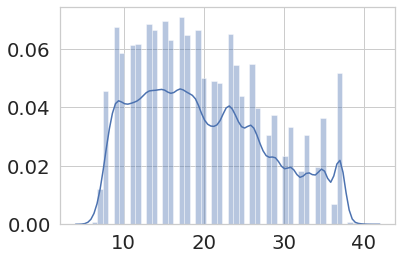

In [46]:
sns.distplot(max_sw)

### Merge & save alignment scores for all fq files

In [47]:
run_id = re.findall(r"runid_(.*)_[\d]+_[\d]+.tsv", sw_tsv)[0]

In [48]:
merged_sw_file = os.path.join(sw_dir, f"all_{run_id}.tsv")

In [49]:
sw.to_csv(merged_sw_file, sep="\t", index=True)

In [50]:
merged_sw_file

'/path/to/data/MinION_sequencing_data_20190813/guppy_3.2.2_08_13_2019_run_03_exec_20190814/sw/all_7efa32b6b7c4b21dadad2a4c078a9f93bd0cc657.tsv'

# Evaluate extant molbits vs rest

## Specify which molbits were actually present

In [51]:
# Create set_N variables based on spreadsheet
molbit_sets = {}
for ix, row in set_spreadsheet.iterrows():
    set_no = re.findall(r"set ([\d]+)", row["set"])[0]
    molbits = row["molbits_in_set"]
    molbit_sets[set_no] = molbits.split(", ")

In [52]:
molbit_set_in_run = str(run_data.get("molbit_set"))
molbit_sets_on_flowcell = run_data.get("prev_on_flowcell")

molbits_in_run = molbit_sets[molbit_set_in_run]
molbits_on_flowcell = molbits_in_run[:]
if molbit_sets_on_flowcell != "none":
    molbit_sets_on_flowcell = molbit_sets_on_flowcell.split(", ")
    for m in molbit_sets_on_flowcell:
        print(m)
        print(molbit_sets[m])
        molbits_on_flowcell.extend(molbit_sets[m])
    print(molbits_on_flowcell)

0
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
1
['16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
['32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


## Extract the best-aligned molbit, across all 96 molbits

This cell replaces "make_sw_call" in the past. No more "-1"s. Just filter by accept_molbit.

In [53]:
sw_scores = sw.filter(regex="score_molbit_.*")
best_molbits = sw_scores.apply(np.argmax, axis=1)
accept_molbit = sw.lookup(sw.index, best_molbits) >= 15
sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [71]:
len(accept_molbit)

245642

In [72]:
sum(accept_molbit)

161628

In [54]:
sum(accept_molbit) / len(accept_molbit)

0.6995261396666694

## Extract the best-aligned molbit, across ONLY the extant molbits

In [55]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_on_flowcell]

In [56]:
extant_sw = sw.loc[:, extant_sw_cols]

In [57]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [58]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [59]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [60]:
n_extant_is_best

169157

Percentage of well-aligned reads that belong to the true set

In [61]:
n_extant_is_best/len(sw_accepted)

0.9844267399160813

Read counts for each molbit

In [62]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('0', 6),
 ('1', 5),
 ('10', 47),
 ('11', 70),
 ('12', 21),
 ('13', 3),
 ('14', 82),
 ('15', 15),
 ('16', 824),
 ('17', 495),
 ('18', 521),
 ('19', 856),
 ('2', 13),
 ('20', 796),
 ('21', 381),
 ('22', 341),
 ('23', 120),
 ('24', 156),
 ('25', 544),
 ('26', 594),
 ('27', 440),
 ('28', 259),
 ('29', 663),
 ('3', 14),
 ('30', 536),
 ('31', 534),
 ('32', 10232),
 ('33', 4071),
 ('34', 3648),
 ('35', 2300),
 ('36', 20994),
 ('37', 13425),
 ('38', 2277),
 ('39', 6898),
 ('4', 8),
 ('40', 11442),
 ('41', 15826),
 ('42', 15789),
 ('43', 29987),
 ('44', 10497),
 ('45', 7127),
 ('46', 3709),
 ('47', 5168),
 ('5', 37),
 ('6', 15),
 ('7', 14),
 ('8', 16),
 ('9', 17)]

## Extract the best-aligned molbit, across ONLY the current run's molbits

In [63]:
extant_sw_cols = [f"sw_score_molbit_{molbit}" for molbit in molbits_in_run]

In [64]:
extant_sw = sw.loc[:, extant_sw_cols]

In [65]:
extant_sw_scores = extant_sw.filter(regex="score_molbit_.*")
best_molbits = extant_sw_scores.apply(np.argmax, axis=1)
accept_molbit = extant_sw.lookup(extant_sw.index, best_molbits) >= 15
extant_sw["best_molbit"] = best_molbits.str.extract(r"score_molbit_([\d]+)")
extant_sw["accept_molbit"] = accept_molbit

/ssd1/home/kdorosch/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


## Compare 

In [66]:
# Only retrieve high-scoring alignments
sw_accepted = sw[sw["accept_molbit"]]
extant_sw_acc = extant_sw[sw["accept_molbit"]]

In [67]:
n_extant_is_best = sum(extant_sw_acc["best_molbit"] == sw_accepted["best_molbit"])

In [68]:
n_extant_is_best

160977

Percentage of well-aligned reads that belong to the true set

In [69]:
n_extant_is_best/len(sw_accepted)

0.9368223798688261

Read counts for each molbit

In [70]:
m, c = np.unique(extant_sw_acc["best_molbit"], return_counts=True)
list(zip(m, c))

[('32', 10606),
 ('33', 4839),
 ('34', 4107),
 ('35', 3437),
 ('36', 21719),
 ('37', 14551),
 ('38', 2710),
 ('39', 7071),
 ('40', 11657),
 ('41', 16228),
 ('42', 16172),
 ('43', 30728),
 ('44', 10597),
 ('45', 7736),
 ('46', 3930),
 ('47', 5745)]

## Get counts for all molbits

In [73]:
m, c = np.unique(sw[sw["accept_molbit"]]["best_molbit"], return_counts=True)
molbit_counts = dict(zip(m, c))
for i in range(96):
    i = str(i)
    if i in molbit_counts:
        print(f"{molbit_counts[i]}")
    else:
        print(f"0")

6
5
9
14
8
23
15
14
13
16
10
32
20
3
10
15
824
413
521
856
796
380
341
120
156
544
594
438
258
663
535
534
10230
4069
3633
2297
19147
13300
2276
6897
11441
15563
15783
29982
10487
7127
3585
5160
1
93
0
1
0
1
4
125
0
0
0
2
1
2
87
0
0
3
5
0
8
470
2
0
4
0
1
543
0
1
0
32
0
0
118
0
1
4
0
0
0
0
1
1154
0
1
4
1
